In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
import torchvision
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import time
import numpy as np

In [2]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
# 它复制了ResNet-18中大部分的预训练层，除了最后的全局平均汇聚层和最接近输出的全连接层。
net = nn.Sequential(*list(pretrained_net.children())[:-2])
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [4]:
# 给定高度为320和宽度为480的输入，net的前向传播将输入的高和宽减小至原来的1/32，即10和15。
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [5]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
# 转置卷积，将特征图还原至原图大小
# 由于图片由(320, 480), (320+16*2-64)/32+1=10, (480+16*2-64)/32+1=15, 到(10, 15), 所以构造64卷积核，padding=16，步幅为32
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32))

In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    """
        上采样核：
        双线性插值法初始化转置卷积层
    """
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [7]:
# 构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用bilinear_kernel函数初始化
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [8]:
img = torchvision.transforms.functional.to_tensor(Image.open(f'../data/img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].detach()

input image shape: torch.Size([561, 728, 3])


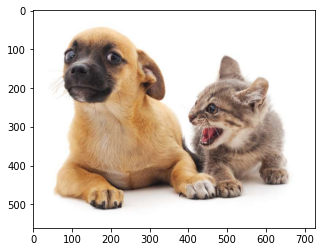

In [9]:
print('input image shape:', img.permute(1, 2, 0).shape)
plt.imshow(img.permute(1, 2, 0));

output image shape: torch.Size([3, 1122, 1456])


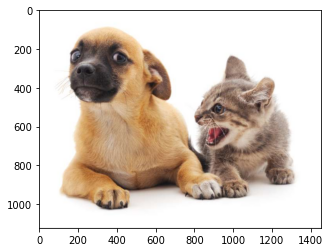

In [10]:
print('output image shape:', out_img.shape)
plt.imshow(out_img.permute(1, 2, 0));

In [11]:
# 网络内转置卷积模块初始化权重
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

# 读取数据集

In [12]:
voc_dir = Path(r'../data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012')

In [13]:
batch_size, crop_size = 16, (320, 480)
train_iter, test_iter = utils.load_data_voc(batch_size, crop_size, voc_dir)

read 1114 examples
read 1078 examples


# 训练

In [14]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(dim=(1, 2))

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, utils.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
utils.train_gpus(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

training on: [device(type='cuda', index=0)], [2024-07-23 01:52:29]
epoch: 1/5, loss: 1.045, train_acc: 0.761, test_acc: 0.814, epoch_time: [0:00:00:50]
epoch: 2/5, loss: 0.645, train_acc: 0.823, test_acc: 0.837, epoch_time: [0:00:00:48]
epoch: 3/5, loss: 0.540, train_acc: 0.842, test_acc: 0.845, epoch_time: [0:00:00:49]
epoch: 4/5, loss: 0.485, train_acc: 0.854, test_acc: 0.851, epoch_time: [0:00:00:51]
epoch: 5/5, loss: 0.440, train_acc: 0.863, test_acc: 0.854, epoch_time: [0:00:00:49]
*** training speed: 33.4 examples/sec on [device(type='cuda', index=0)], all_time: [0:00:04:09] ***


# 预测

In [15]:
test_images, test_labels = utils.read_voc_images(voc_dir, False)

In [16]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0]))
    print(pred.shape)
    pred = pred.argmax(dim=1)
    print(pred.shape)
    pred = pred.reshape(pred.shape[1], pred.shape[2])
    print(pred.shape)
    return pred

In [17]:
def label2image(pred):
    """
        label_index to 3 channel img tensor
    """
    colormap = torch.tensor(utils.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

torch.Size([1, 21, 320, 480])
torch.Size([1, 320, 480])
torch.Size([320, 480])
torch.Size([1, 21, 320, 480])
torch.Size([1, 320, 480])
torch.Size([320, 480])
torch.Size([1, 21, 320, 480])
torch.Size([1, 320, 480])
torch.Size([320, 480])
torch.Size([1, 21, 320, 480])
torch.Size([1, 320, 480])
torch.Size([320, 480])


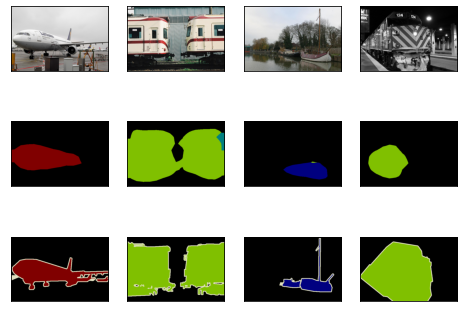

In [18]:
n, imgs = 4, []
crop_rect = (0, 0, 320, 480)
for i in range(n):
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs.extend([X.permute(1,2,0), pred.cpu(), torchvision.transforms.functional.crop(test_labels[i], *crop_rect).permute(1,2,0)])
utils.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

In [19]:
# for X, Y in train_iter:
#     print(X.shape, Y.shape)
#     break

# x = torch.rand(size=(2, 12, 4, 4))
# # x = x.unsqueeze(0)
# y = torch.randint(low=0, high=10, size=(2, 4, 4))
# # y = y.unsqueeze(0)
# print(x.shape, y.shape)
# loss = F.cross_entropy(x, y, reduction='none').mean(dim=(1, 2))
# loss = F.cross_entropy(x, y, reduction='none').mean(1).mean(1)
# print(loss.shape)
# print(loss)